# Library

In [2]:
import numpy as np, os
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

# GPU 용량 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# 함수 모음

## RF_정확도(itemlist, name)

In [7]:
def RF_정확도(itemlist,name):

    # itemlist만을 가진 x_(7727,10)_itemlist 만들기
    item_list = list(total_data['ITEMID'].sort_values().unique())
    
    item_index = []
    for i in itemlist:
        item_index.append(item_list.index(i))

    print('itemlist의 index : ',item_index)

    x = np.load('x_(7727,4068).npy')
    x_2d = x[:,item_index]
    x_2d
    
    np.save(f'x_(7727,10)_{name}.npy',x_2d)
    
    import random
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score

    model = RandomForestClassifier()

    data={}
    for seed in range(42, 52):
        random.seed(seed)
        
        x = np.load(f'./x_(7727,10)_{name}.npy')
        y = np.load('./y_(7727,1).npy')

        idx = list(range(len(x)))
        random.shuffle(idx)

        i = round(x.shape[0]*0.8)
        X_train, y_train = x[idx[:i],:], y[idx[:i]]
        X_test, y_test = x[idx[i:],:], y[idx[i:]]

        _ = model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred_test)
        data[seed]=acc
        print(f'정확도 : {acc}, seed_num = {seed}')

    df = pd.DataFrame.from_dict(data, orient='index')
    print(f'정확도 df 만들고 평균 확인 : {df.mean().values}')    

## LSTM_정확도(itemlist, name)

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics 
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

import random

def LSTM_정확도(itemlist, name):

    # itemlist만을 가진 x_(7727,10,10)_itemlist 만들기
    total_data = pd.read_csv('total_data_7727.csv')
    item_list = list(total_data['ITEMID'].sort_values().unique())

    item_index = []
    for i in itemlist:
        item_index.append(item_list.index(i))

    print('itemlist의 index : ',item_index)

    x = np.load('x_(7727,10,4068).npy')
    x_3d = x[:,:,item_index]
    
    np.save(f'x_(7727,10,10)_{name}.npy',x_3d)
    
    seed_num = 42
    random.seed(seed_num)
    
    x = np.load(f'x_(7727,10,10)_{name}.npy')
    y = np.load('y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

    # ---------------------
    seed_num = 42 
    # ---------------------
    tf.random.set_seed(seed_num)

    lstm = Sequential()
    lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units=1, activation='sigmoid'))

    from tensorflow.keras.callbacks import ModelCheckpoint
    import os

    MODEL_SAVE_FOLDER_PATH = f'./model/{name}'
    if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
        os.mkdir(MODEL_SAVE_FOLDER_PATH)

    model_path = MODEL_SAVE_FOLDER_PATH + f'/{name}_seed42-'+'{epoch:02d}'+'-{val_loss:.4f}.hdf5'

    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                    verbose=1, save_best_only=True)

    early_stop = EarlyStopping(monitor='val_acc', patience=50, verbose=1, restore_best_weights=True)
    lstm.compile(optimizer= keras.optimizers.Adam(learning_rate = 0.001), loss = "binary_crossentropy", metrics=['acc'])
    lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop,cb_checkpoint], shuffle=False)
    
    with tf.device('/device:GPU:0'):
        tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

        from pathlib import Path
        paths = sorted(Path(MODEL_SAVE_FOLDER_PATH).iterdir(), key=os.path.getmtime)[-1]
        best_model_path = str(paths)

        from keras.models import load_model
        best_model = load_model(best_model_path) 

        dic_42={}
        for seed in range(0, 50):
            random.seed(seed)

            x = np.load(f'x_(7727,10,10)_{name}.npy')
            y = np.load('y_(7727,1).npy')

            idx = list(range(len(x)))
            random.shuffle(idx)

            i = round(x.shape[0]*0.8)
            X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
            X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

            pred = best_model.predict(X_test)
            pred[pred>0.5]=1
            pred[pred<=0.5]=0
            acc = metrics.accuracy_score(y_test, pred)
            dic_42[seed]=acc
            print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

        df_42 = pd.DataFrame.from_dict(dic_42, orient='index')
        print(f'정확도 df 만들고 평균 확인 : {df_42.mean().values}')

## absum(PPL_list, top_or_down)

In [9]:
total_data = pd.read_csv('total_data_7727.csv')
x = np.load('/project/LSH/x_(7727,10,4068).npy')

def absum(PPL_list,top_or_down):
    # 1) PRE_top10의 index 구하기
    PPL_top10 = top_or_down
    item_list = total_data['ITEMID'].sort_values().unique()

    PPL_index = []
    for i in PPL_top10:
        a = list(item_list).index(i)
        PPL_index.append(a)
    
    # 2) 생존자 index 구하기 
    sub7727 = total_data['SUBJECT_ID'].unique()

    patient = pd.read_csv('폐렴환자.csv')
    patient = patient.sort_values(by='SUBJECT_ID')
    patient = patient[patient['SUBJECT_ID'].isin(sub7727)]
    sub_1_list = patient[patient['EXPIRE_FLAG']==0]['SUBJECT_ID'].values

    생존자_index = []
    for i in sub_1_list:
        생존자_index.append(list(sub7727).index(i))
        
    # 3) 생존자 3009명의 D-10 ~ D-1 feature별 abnormal sum 
    x_생존자 = x[생존자_index,:,:]

    result1 = []
    for i in PPL_index:
        for j in range(10):
            result1.append(x_생존자[:,j,i].sum())

    result1 = np.array(result1)
    result1 = result1.reshape(10,-1)
    df_PPL = pd.DataFrame(result1)
    df_PPL.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL.index = PPL_top10

    # 생존한 4718명에 대한 비율 계산
    for i in PPL_top10:
        df_PPL.loc[f'{i}_생존'] = df_PPL.loc[i].iloc[:]/x_생존자.shape[0]
        
    # 4) 사망자 4718명의 D-10 ~ D-1 feature별 abnormal sum 
    사망자_index = list(set(range(0,7727))-set(생존자_index))

    x_사망자 = x[사망자_index,:,:]

    result2 = []
    for i in PPL_index:
        for j in range(10):
            result2.append(x_사망자[:,j,i].sum())

    result2 = np.array(result2)
    result2 = result2.reshape(10,-1)
    df_PPL_사망자 = pd.DataFrame(result2)
    df_PPL_사망자.columns = [f'D-{i}' for i in range(10,0,-1)]
    df_PPL_사망자.index = PPL_top10

    # 사망한 3009명에 대한 비율 계산
    for i in PPL_top10:
        df_PPL_사망자.loc[f'{i}_사망'] = df_PPL_사망자.loc[i]/x_사망자.shape[0] 
        
    # 5) for문으로 각 feature에 대한 비율 추이 그래프 그리기 

    df_PPL_trans = df_PPL.transpose()
    df_PPL_사망자_trans = df_PPL_사망자.transpose()

    _ = plt.figure(figsize = (13,12),dpi=150)
    for i, f in enumerate(PPL_top10): 
        _ = plt.subplot(4,3,1+i)
        _ = plt.title(f)
        _ = ax = sns.lineplot(data = df_PPL_사망자_trans, x = df_PPL_사망자_trans.index, y = f'{f}_사망')
        _ = ax = sns.lineplot(data = df_PPL_trans, x = df_PPL_trans.index, y = f'{f}_생존')
        _ = ax.legend(labels = ['사망', '생존'], loc = 'upper left', fontsize=12)
        _ = ax.set_ylabel('per', fontsize = 12)

    plt.tight_layout()

## FI_merge(itemid)

In [10]:
def FI_merge(itemid):
    
    # 1) DATA 
    import random    
    seed_num = 42
    random.seed(seed_num)

    x = np.load('/project/LSH/x_(7727,10,4068).npy')
    y = np.load('/project/LSH/y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

    with tf.device('/device:GPU:0'):
        tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])
        # 2) MODEL
        from keras.models import load_model
        lstm2 = load_model('./model/(LSTM_best_4068)seed42-05-0.5029.hdf5')
    
    # for문 돌릴 때 X_test 복원용 
    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    # 3) 환자별 base pred (Y')
    base_pred = pd.DataFrame(lstm2.predict(X_test))
    
    total_data = pd.read_csv('total_data_7727.csv')
    features = total_data['ITEMID'].sort_values().unique()

    k = list(features).index(itemid)
    save_col = X_test[:,:,k].copy()

    # 4) 0 to 1
    X_test[:,:,k]= np.where(X_test[:,:,k]==0, 1, X_test[:,:,k])
    pred_0to1 = pd.DataFrame(lstm2.predict(X_test))

    # 5) 1 to 0
    X_test[:,:,k] = np.where(X_test[:,:,k]==1, 0, X_test[:,:,k])
    pred_1to0 = pd.DataFrame(lstm2.predict(X_test))

    # 6) inverse
    X_test[:,:,k] = save_col
    X_test[:,:,k] = np.where(X_test[:,:,k]==1, 2, X_test[:,:,k])
    X_test[:,:,k] = np.where(X_test[:,:,k]==0, 1, X_test[:,:,k])
    X_test[:,:,k] = np.where(X_test[:,:,k]==2, 0, X_test[:,:,k])
    pred_inverse = pd.DataFrame(lstm2.predict(X_test))

    # 7) Merge & Visualize
    FI_merge_df = pd.concat([base_pred, pred_0to1, pred_1to0, pred_inverse], axis=1)
    FI_merge_df.columns = ['base_pred', 'pred_0to1', 'pred_1to0', 'pred_inverse']
    FI_merge_visual = FI_merge_df.melt(value_vars=['base_pred','pred_0to1','pred_1to0','pred_inverse'])
    FI_merge_visual.columns = ['method','pred_value']
    
    ax = plt.figure(figsize=(7,5),dpi=100)
    ax = sns.violinplot(data=FI_merge_visual, x='method',y='pred_value',
                        palette="Set2", inner="quartile")
    _ = plt.title(itemid)

# m1_new 생성

In [14]:
entropy = pd.read_csv('m1_entropy.csv')
entropy = entropy.sort_values(by='feature')
entropy.index = range(4068)

mm = pd.read_csv('FI_mean_merge.csv')
mm['mean_diff'] = mm['pred_0to1']-mm['pred_1to0']
mm = mm.sort_values(by='feature')
mm['entropy'] = entropy['entropy']
mm['m1_new'] = mm['mean_diff'] * mm['entropy']
m1_new = mm.sort_values(by='m1_new', ascending=False)
# m1_new.to_csv('m1_new.csv',index=False)

In [15]:
m1_new = pd.read_csv('m1_new.csv')
m1_new

,feature,pred_0to1,pred_1to0,pred_inverse,baseline,mean_diff,entropy,m1_new
0,51277,0.718487,0.582343,0.693639,0.636932,0.136144,0.919332,0.125161
1,51006,0.692667,0.581710,0.668543,0.636932,0.110958,0.980942,0.108843
2,50912,0.678140,0.607378,0.676969,0.636932,0.070762,0.848272,0.060025
3,50882,0.682766,0.607949,0.682174,0.636932,0.074817,0.767764,0.057442
4,409176230,0.719983,0.615389,0.724965,0.636932,0.104593,0.380630,0.039811
...,...,...,...,...,...,...,...,...
4063,51237,0.592904,0.628682,0.613074,0.636932,-0.035778,0.742306,-0.026558
4064,50861,0.529173,0.629188,0.549854,0.636932,-0.100014,0.400005,-0.040006
4065,51249,0.556241,0.631692,0.579608,0.636932,-0.075451,0.552624,-0.041696
4066,0,0.602555,0.664229,0.658366,0.636932,-0.061674,0.894548,-0.055171


# m1_new_top10

In [4]:
m1_new = pd.read_csv('m1_new.csv')
m1_new_top10 = m1_new['feature'].values[:10]
m1_new_top10

array([    51277,     51006,     50912,     50882, 409176230,     50862,
           51003,     50983,     50893, 487980125])

## (65.5) RF

In [15]:
RF_정확도(m1_new_top10,'m1_new_top10')

itemlist의 index :  [206, 121, 56, 34, 2148, 20, 119, 103, 41, 2291]
정확도 : 0.6608414239482201, seed_num = 42
정확도 : 0.6537216828478964, seed_num = 43
정확도 : 0.6323624595469256, seed_num = 44
정확도 : 0.6388349514563106, seed_num = 45
정확도 : 0.658252427184466, seed_num = 46
정확도 : 0.6660194174757281, seed_num = 47
정확도 : 0.6770226537216828, seed_num = 48
정확도 : 0.656957928802589, seed_num = 49
정확도 : 0.6595469255663431, seed_num = 50
정확도 : 0.6498381877022654, seed_num = 51
정확도 df 만들고 평균 확인 : [0.65533981]


## (70.4) LSTM

In [16]:
LSTM_정확도(m1_new_top10,'m1_new_top10')

itemlist의 index :  [206, 121, 56, 34, 2148, 20, 119, 103, 41, 2291]
Epoch 1/500
37/37 [==============================] - 6s 74ms/step - loss: 0.6758 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66597, saving model to ./model/m1_new_top10/m1_new_top10_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6731 - acc: 0.6068 - val_loss: 0.6661 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66597
Epoch 3/500
37/37 [==============================] - 2s 64ms/step - loss: 0.6734 - acc: 0.6083 - val_loss: 0.6646 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66597 to 0.66464, saving model to ./model/m1_new_top10/m1_new_top10_seed42-03-0.6646.hdf5
Epoch 4/500
37/37 [==============================] - 2s 65ms/step - loss: 0.6646 - acc: 0.6117 - val_loss: 0.6475 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66464 to 0.64746, saving model to ./model/m1_new_top10/m1_n

37/37 [==============================] - 2s 65ms/step - loss: 0.5768 - acc: 0.7008 - val_loss: 0.5878 - val_acc: 0.6831

Epoch 00031: val_loss did not improve from 0.58762
Epoch 32/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5802 - acc: 0.7021 - val_loss: 0.5863 - val_acc: 0.6805

Epoch 00032: val_loss improved from 0.58762 to 0.58634, saving model to ./model/m1_new_top10/m1_new_top10_seed42-32-0.5863.hdf5
Epoch 33/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5777 - acc: 0.7032 - val_loss: 0.5862 - val_acc: 0.6779

Epoch 00033: val_loss improved from 0.58634 to 0.58621, saving model to ./model/m1_new_top10/m1_new_top10_seed42-33-0.5862.hdf5
Epoch 34/500
37/37 [==============================] - 2s 62ms/step - loss: 0.5756 - acc: 0.7041 - val_loss: 0.5867 - val_acc: 0.6818

Epoch 00034: val_loss did not improve from 0.58621
Epoch 35/500
37/37 [==============================] - 2s 65ms/step - loss: 0.5769 - acc: 0.7030 - val_loss: 0.5873 - va

37/37 [==============================] - 2s 64ms/step - loss: 0.5660 - acc: 0.7129 - val_loss: 0.5823 - val_acc: 0.6928

Epoch 00070: val_loss did not improve from 0.58186
Epoch 71/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5609 - acc: 0.7079 - val_loss: 0.5830 - val_acc: 0.6921

Epoch 00071: val_loss did not improve from 0.58186
Epoch 72/500
37/37 [==============================] - 2s 62ms/step - loss: 0.5626 - acc: 0.7099 - val_loss: 0.5836 - val_acc: 0.6902

Epoch 00072: val_loss did not improve from 0.58186
Epoch 73/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5627 - acc: 0.7110 - val_loss: 0.5822 - val_acc: 0.6921

Epoch 00073: val_loss did not improve from 0.58186
Epoch 74/500
37/37 [==============================] - 2s 65ms/step - loss: 0.5636 - acc: 0.7138 - val_loss: 0.5824 - val_acc: 0.6921

Epoch 00074: val_loss did not improve from 0.58186
Epoch 75/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5627 - acc:

37/37 [==============================] - 2s 65ms/step - loss: 0.5507 - acc: 0.7194 - val_loss: 0.5820 - val_acc: 0.6902

Epoch 00112: val_loss did not improve from 0.58051
Epoch 113/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5496 - acc: 0.7196 - val_loss: 0.5831 - val_acc: 0.6902

Epoch 00113: val_loss did not improve from 0.58051
Epoch 114/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5518 - acc: 0.7222 - val_loss: 0.5818 - val_acc: 0.6889

Epoch 00114: val_loss did not improve from 0.58051
Epoch 115/500
37/37 [==============================] - 2s 65ms/step - loss: 0.5514 - acc: 0.7241 - val_loss: 0.5813 - val_acc: 0.6921

Epoch 00115: val_loss did not improve from 0.58051
Epoch 116/500
37/37 [==============================] - 2s 64ms/step - loss: 0.5493 - acc: 0.7202 - val_loss: 0.5830 - val_acc: 0.6921

Epoch 00116: val_loss did not improve from 0.58051
Epoch 117/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5482 -

37/37 [==============================] - 2s 65ms/step - loss: 0.5329 - acc: 0.7289 - val_loss: 0.6017 - val_acc: 0.6973

Epoch 00156: val_loss did not improve from 0.58051
Epoch 157/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5363 - acc: 0.7274 - val_loss: 0.5984 - val_acc: 0.6921

Epoch 00157: val_loss did not improve from 0.58051
Epoch 158/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5335 - acc: 0.7282 - val_loss: 0.6031 - val_acc: 0.6882

Epoch 00158: val_loss did not improve from 0.58051
Epoch 159/500
37/37 [==============================] - 2s 62ms/step - loss: 0.5351 - acc: 0.7235 - val_loss: 0.5981 - val_acc: 0.6940

Epoch 00159: val_loss did not improve from 0.58051
Epoch 160/500
37/37 [==============================] - 2s 62ms/step - loss: 0.5326 - acc: 0.7252 - val_loss: 0.5968 - val_acc: 0.6902

Epoch 00160: val_loss did not improve from 0.58051
Epoch 161/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5320 -

37/37 [==============================] - 2s 64ms/step - loss: 0.5200 - acc: 0.7392 - val_loss: 0.5978 - val_acc: 0.6908

Epoch 00200: val_loss did not improve from 0.58051
Epoch 201/500
37/37 [==============================] - 2s 65ms/step - loss: 0.5212 - acc: 0.7403 - val_loss: 0.6008 - val_acc: 0.6908

Epoch 00201: val_loss did not improve from 0.58051
Epoch 202/500
37/37 [==============================] - 2s 65ms/step - loss: 0.5174 - acc: 0.7377 - val_loss: 0.6030 - val_acc: 0.6908

Epoch 00202: val_loss did not improve from 0.58051
Epoch 203/500
37/37 [==============================] - 2s 65ms/step - loss: 0.5181 - acc: 0.7407 - val_loss: 0.6030 - val_acc: 0.6908

Epoch 00203: val_loss did not improve from 0.58051
Epoch 204/500
37/37 [==============================] - 2s 63ms/step - loss: 0.5166 - acc: 0.7384 - val_loss: 0.6007 - val_acc: 0.6921

Epoch 00204: val_loss did not improve from 0.58051
Epoch 205/500
37/37 [==============================] - 2s 62ms/step - loss: 0.5172 -

정확도 :0.7003236245954693, seed_num = 2
정확도 :0.7100323624595469, seed_num = 3
정확도 :0.7080906148867314, seed_num = 4
정확도 :0.7022653721682848, seed_num = 5
정확도 :0.6899676375404531, seed_num = 6
정확도 :0.7022653721682848, seed_num = 7
정확도 :0.7132686084142394, seed_num = 8
정확도 :0.7029126213592233, seed_num = 9
정확도 :0.7055016181229773, seed_num = 10
정확도 :0.7022653721682848, seed_num = 11
정확도 :0.7152103559870551, seed_num = 12
정확도 :0.7074433656957929, seed_num = 13
정확도 :0.7061488673139159, seed_num = 14
정확도 :0.7016181229773463, seed_num = 15
정확도 :0.7126213592233009, seed_num = 16
정확도 :0.7016181229773463, seed_num = 17
정확도 :0.7171521035598706, seed_num = 18
정확도 :0.7035598705501618, seed_num = 19
정확도 :0.7009708737864078, seed_num = 20
정확도 :0.684789644012945, seed_num = 21
정확도 :0.6990291262135923, seed_num = 22
정확도 :0.6886731391585761, seed_num = 23
정확도 :0.6873786407766991, seed_num = 24
정확도 :0.7190938511326861, seed_num = 25
정확도 :0.6957928802588996, seed_num = 26
정확도 :0.6957928802588996, seed_num 

## absum 그래프

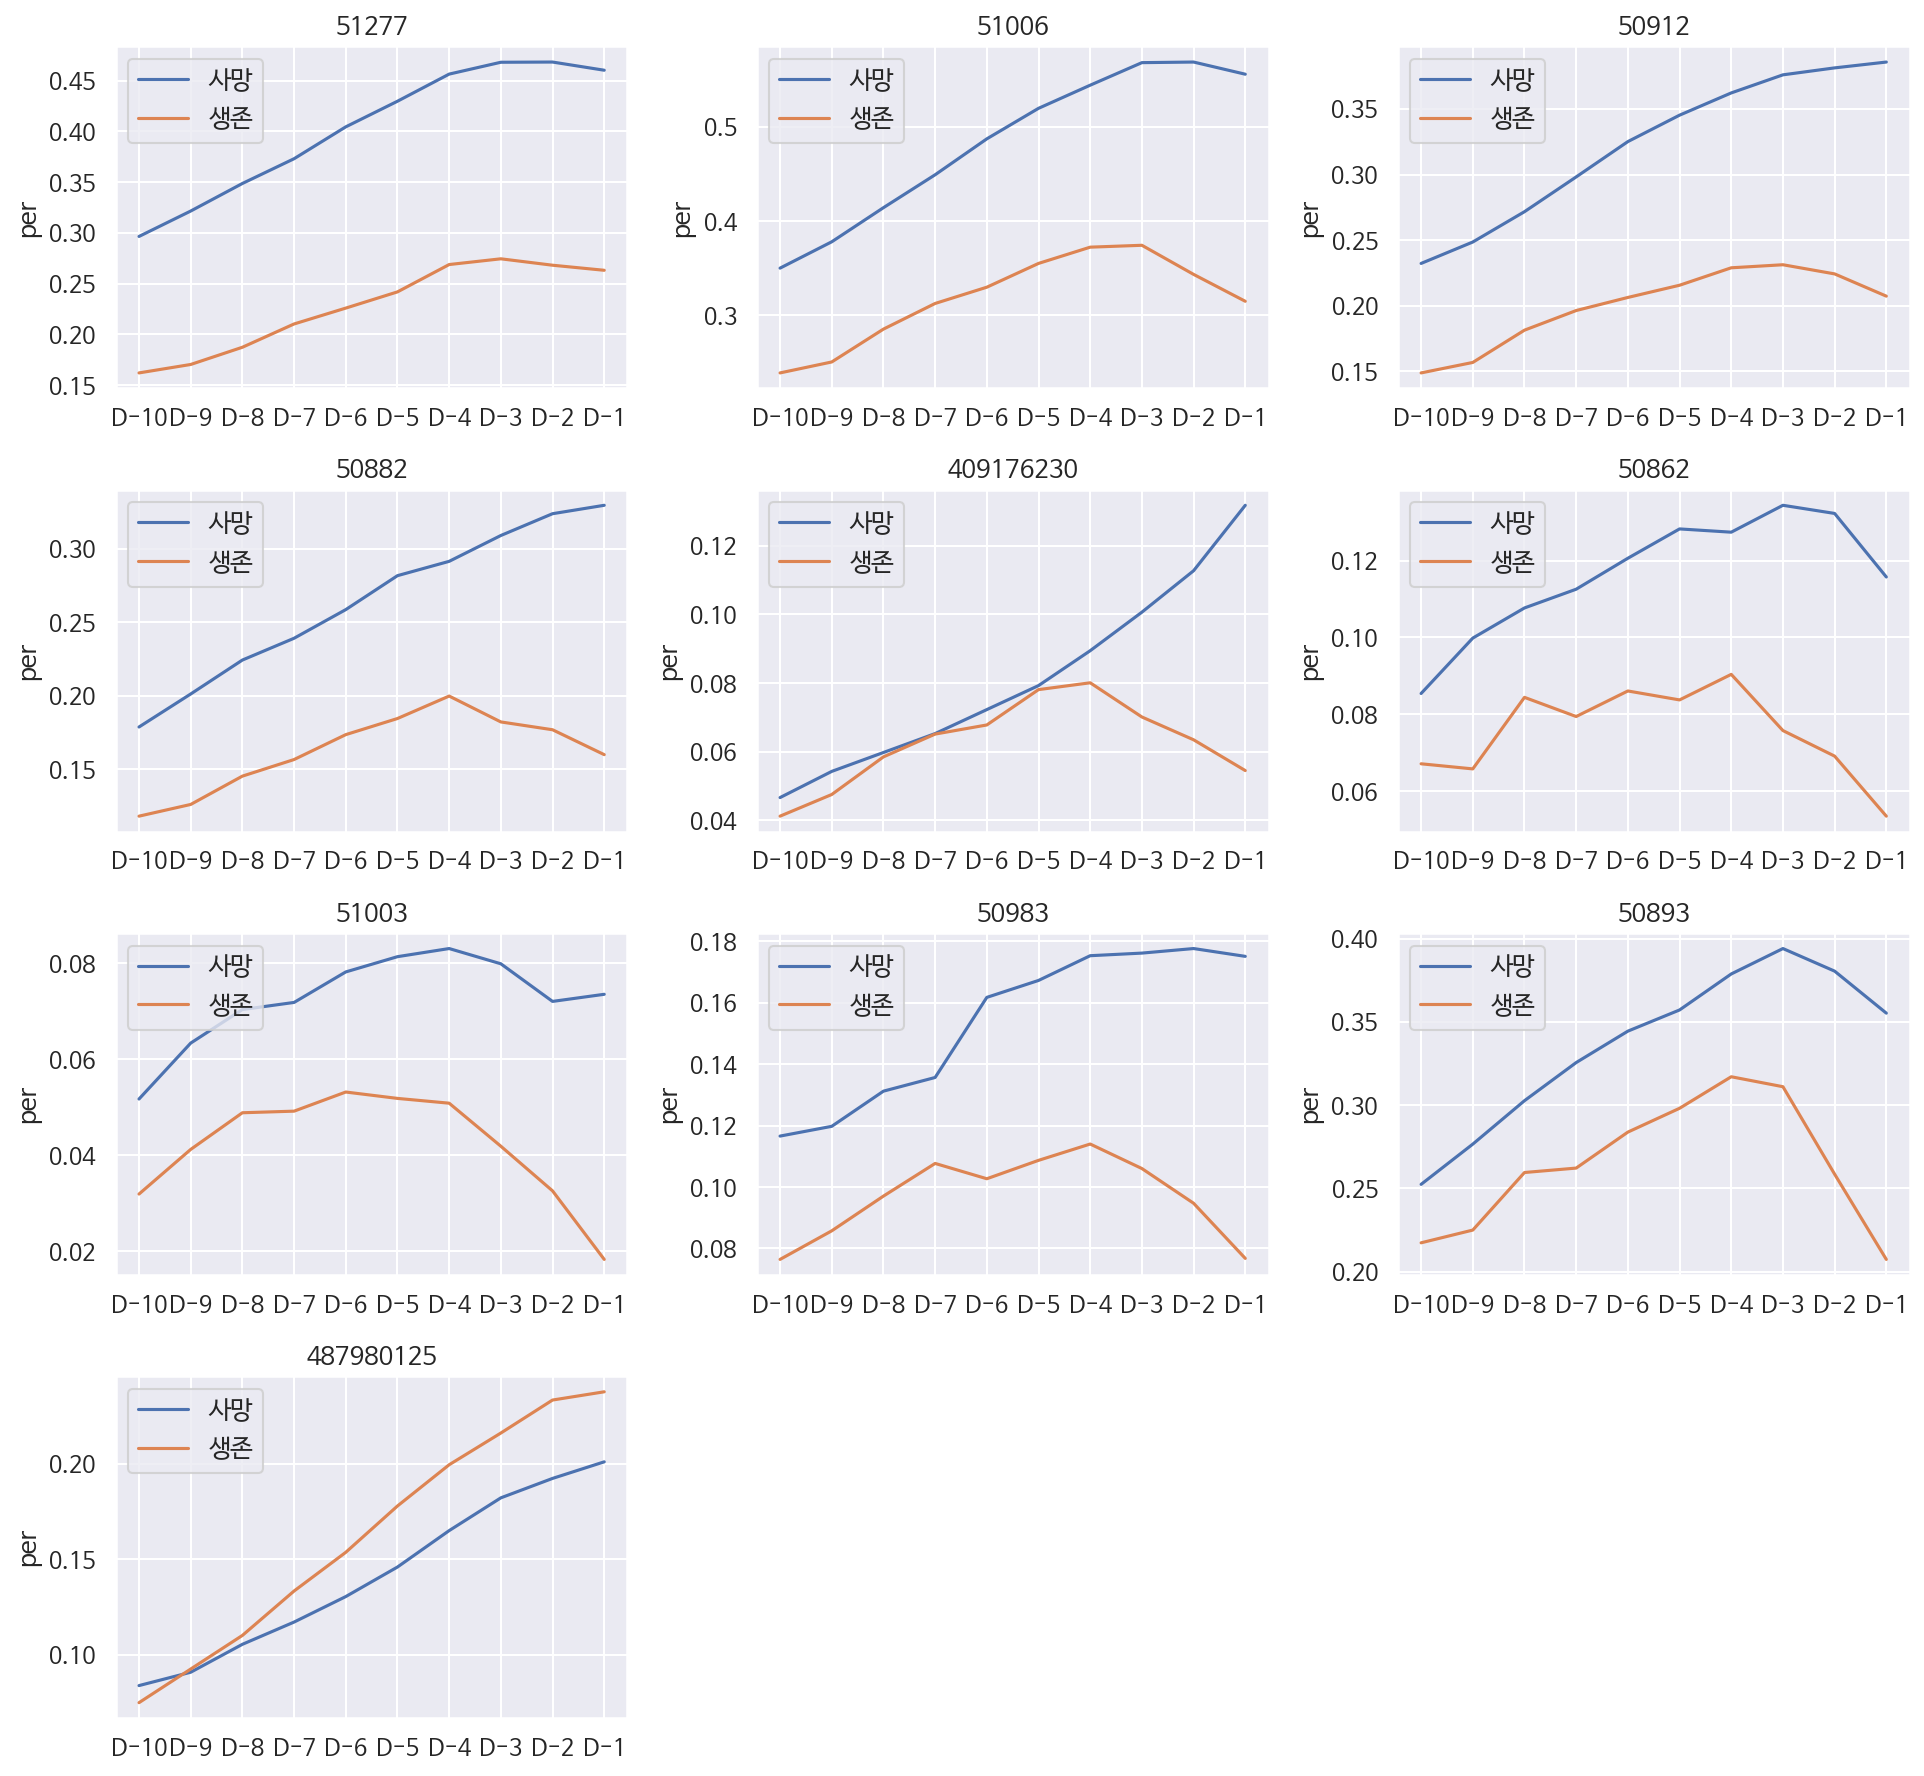

In [21]:
m1_new_top10 = list(m1_new_top10)
absum(m1_new_top10,m1_new_top10[:10])

## violin plot

100%|██████████| 10/10 [00:49<00:00,  4.94s/it]


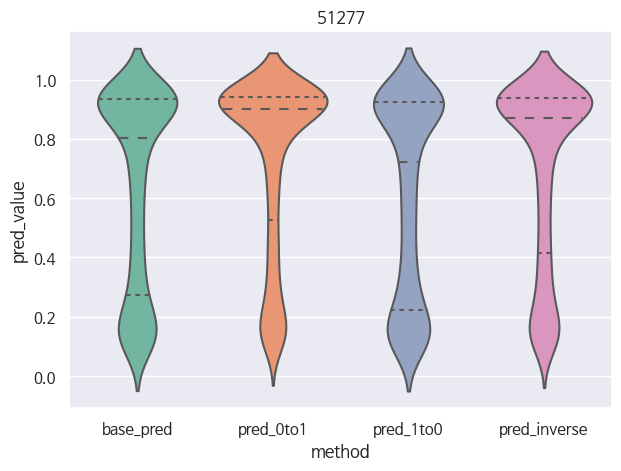

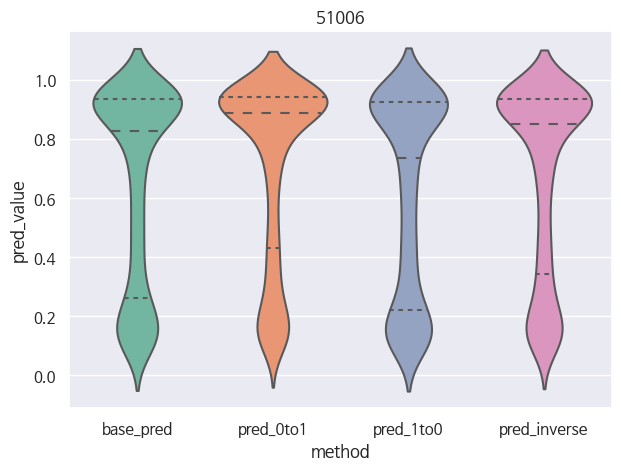

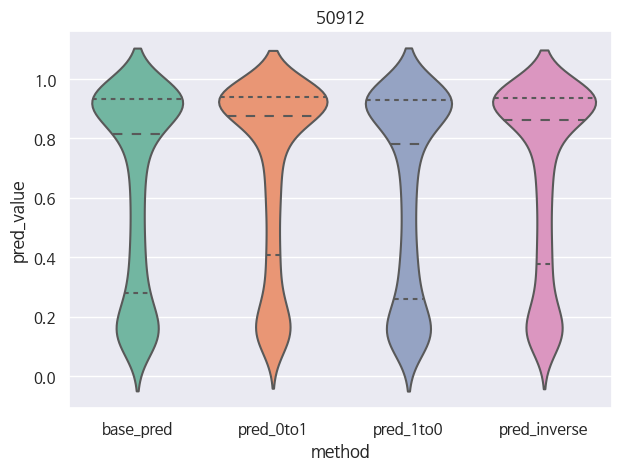

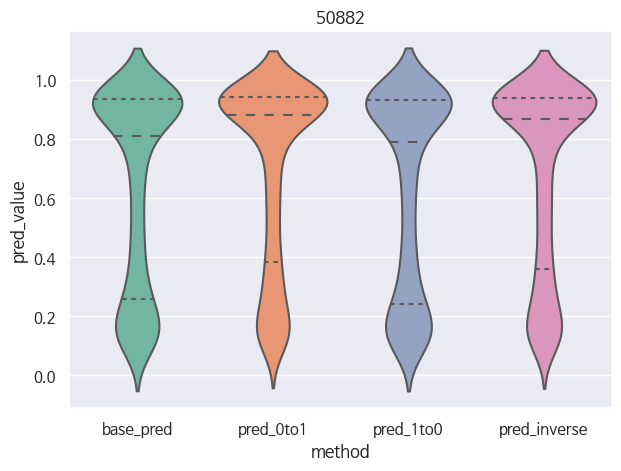

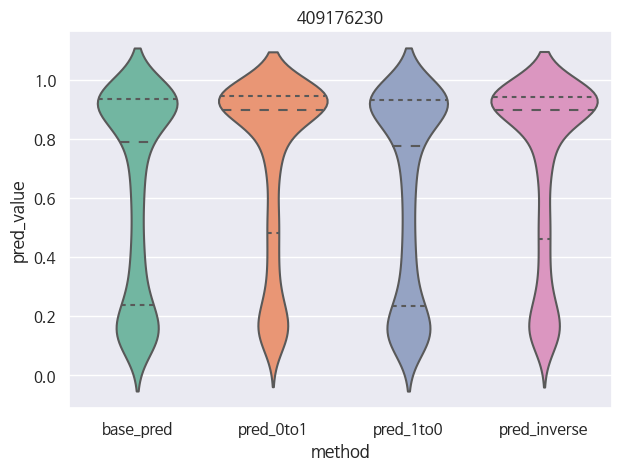

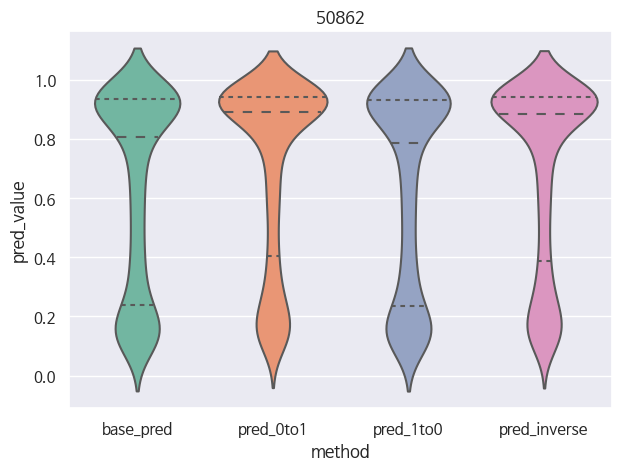

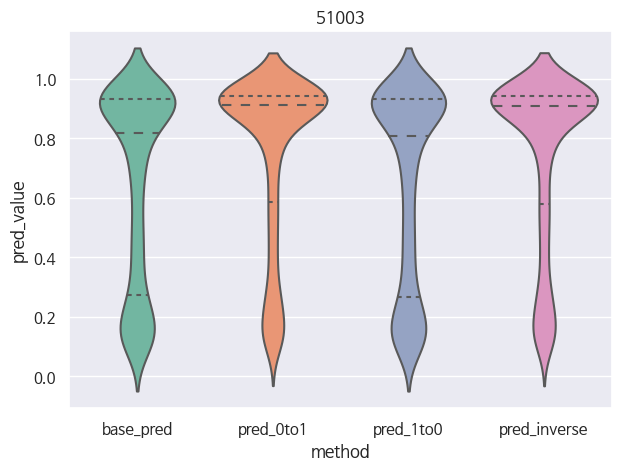

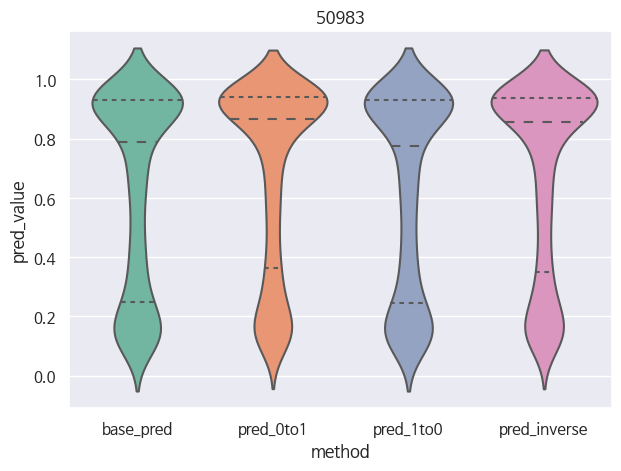

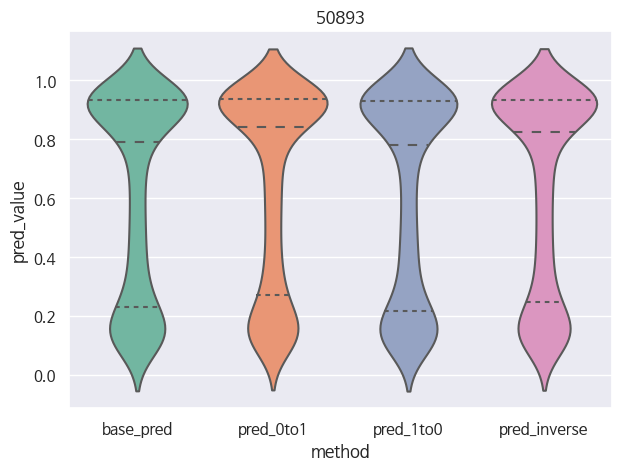

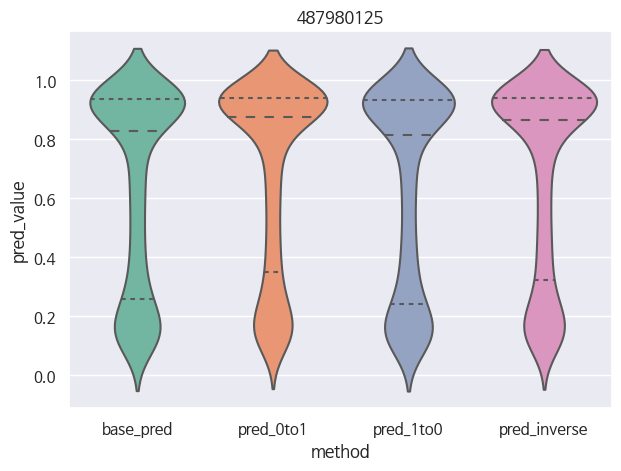

In [25]:
for i in tqdm(m1_new_top10):
    FI_merge(i)

# m1_new_bottom10

In [5]:
m1_new = pd.read_csv('m1_new.csv')
m1_new_bottom10 = m1_new['feature'].values[-10:]
m1_new_bottom10

array([  409672924, 55390000401,      224277,     8084199,       51221,
             51237,       50861,       51249,           0, 63323026201])

## (63.5) RF

In [11]:
RF_정확도(m1_new_bottom10,'m1_new_bottom10')

itemlist의 index :  [2212, 3456, 307, 619, 174, 182, 19, 187, 0, 3832]
정확도 : 0.6148867313915858, seed_num = 42
정확도 : 0.6233009708737864, seed_num = 43
정확도 : 0.6148867313915858, seed_num = 44
정확도 : 0.6576051779935275, seed_num = 45
정확도 : 0.6433656957928803, seed_num = 46
정확도 : 0.6537216828478964, seed_num = 47
정확도 : 0.6472491909385113, seed_num = 48
정확도 : 0.6245954692556634, seed_num = 49
정확도 : 0.6530744336569579, seed_num = 50
정확도 : 0.623948220064725, seed_num = 51
정확도 df 만들고 평균 확인 : [0.63566343]


## (67) LSTM

In [12]:
LSTM_정확도(m1_new_bottom10,'m1_new_bottom10')

itemlist의 index :  [2212, 3456, 307, 619, 174, 182, 19, 187, 0, 3832]
Epoch 1/500
37/37 [==============================] - 6s 72ms/step - loss: 0.6759 - acc: 0.5984 - val_loss: 0.6660 - val_acc: 0.6177

Epoch 00001: val_loss improved from inf to 0.66601, saving model to ./model/m1_new_bottom10/m1_new_bottom10_seed42-01-0.6660.hdf5
Epoch 2/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6732 - acc: 0.6066 - val_loss: 0.6662 - val_acc: 0.6177

Epoch 00002: val_loss did not improve from 0.66601
Epoch 3/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6740 - acc: 0.6083 - val_loss: 0.6655 - val_acc: 0.6177

Epoch 00003: val_loss improved from 0.66601 to 0.66547, saving model to ./model/m1_new_bottom10/m1_new_bottom10_seed42-03-0.6655.hdf5
Epoch 4/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6710 - acc: 0.6100 - val_loss: 0.6652 - val_acc: 0.6177

Epoch 00004: val_loss improved from 0.66547 to 0.66517, saving model to ./model/m1_

37/37 [==============================] - 2s 62ms/step - loss: 0.6394 - acc: 0.6260 - val_loss: 0.6326 - val_acc: 0.6339

Epoch 00033: val_loss improved from 0.63269 to 0.63264, saving model to ./model/m1_new_bottom10/m1_new_bottom10_seed42-33-0.6326.hdf5
Epoch 34/500
37/37 [==============================] - 2s 62ms/step - loss: 0.6403 - acc: 0.6281 - val_loss: 0.6316 - val_acc: 0.6345

Epoch 00034: val_loss improved from 0.63264 to 0.63155, saving model to ./model/m1_new_bottom10/m1_new_bottom10_seed42-34-0.6316.hdf5
Epoch 35/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6394 - acc: 0.6301 - val_loss: 0.6309 - val_acc: 0.6345

Epoch 00035: val_loss improved from 0.63155 to 0.63089, saving model to ./model/m1_new_bottom10/m1_new_bottom10_seed42-35-0.6309.hdf5
Epoch 36/500
37/37 [==============================] - 2s 62ms/step - loss: 0.6403 - acc: 0.6322 - val_loss: 0.6314 - val_acc: 0.6404

Epoch 00036: val_loss did not improve from 0.63089
Epoch 37/500
37/37 [====

37/37 [==============================] - 2s 62ms/step - loss: 0.6214 - acc: 0.6689 - val_loss: 0.6208 - val_acc: 0.6649

Epoch 00070: val_loss did not improve from 0.62009
Epoch 71/500
37/37 [==============================] - 2s 62ms/step - loss: 0.6196 - acc: 0.6659 - val_loss: 0.6211 - val_acc: 0.6636

Epoch 00071: val_loss did not improve from 0.62009
Epoch 72/500
37/37 [==============================] - 2s 63ms/step - loss: 0.6196 - acc: 0.6661 - val_loss: 0.6205 - val_acc: 0.6636

Epoch 00072: val_loss did not improve from 0.62009
Epoch 73/500
37/37 [==============================] - 2s 62ms/step - loss: 0.6209 - acc: 0.6691 - val_loss: 0.6195 - val_acc: 0.6617

Epoch 00073: val_loss improved from 0.62009 to 0.61953, saving model to ./model/m1_new_bottom10/m1_new_bottom10_seed42-73-0.6195.hdf5
Epoch 74/500
37/37 [==============================] - 2s 62ms/step - loss: 0.6211 - acc: 0.6678 - val_loss: 0.6203 - val_acc: 0.6578

Epoch 00074: val_loss did not improve from 0.61953
Epoch

Using TensorFlow backend.


정확도 :0.6666666666666666, seed_num = 0
정확도 :0.6627831715210356, seed_num = 1
정확도 :0.6744336569579288, seed_num = 2
정확도 :0.6608414239482201, seed_num = 3
정확도 :0.6718446601941748, seed_num = 4
정확도 :0.6802588996763754, seed_num = 5
정확도 :0.6731391585760518, seed_num = 6
정확도 :0.6530744336569579, seed_num = 7
정확도 :0.6822006472491909, seed_num = 8
정확도 :0.6822006472491909, seed_num = 9
정확도 :0.6673139158576051, seed_num = 10
정확도 :0.6783171521035599, seed_num = 11
정확도 :0.6608414239482201, seed_num = 12
정확도 :0.6530744336569579, seed_num = 13
정확도 :0.6873786407766991, seed_num = 14
정확도 :0.6925566343042071, seed_num = 15
정확도 :0.6776699029126214, seed_num = 16
정확도 :0.654368932038835, seed_num = 17
정확도 :0.6666666666666666, seed_num = 18
정확도 :0.658252427184466, seed_num = 19
정확도 :0.6686084142394823, seed_num = 20
정확도 :0.654368932038835, seed_num = 21
정확도 :0.658252427184466, seed_num = 22
정확도 :0.6692556634304208, seed_num = 23
정확도 :0.6640776699029126, seed_num = 24
정확도 :0.6621359223300971, seed_num = 25


## absum 그래프

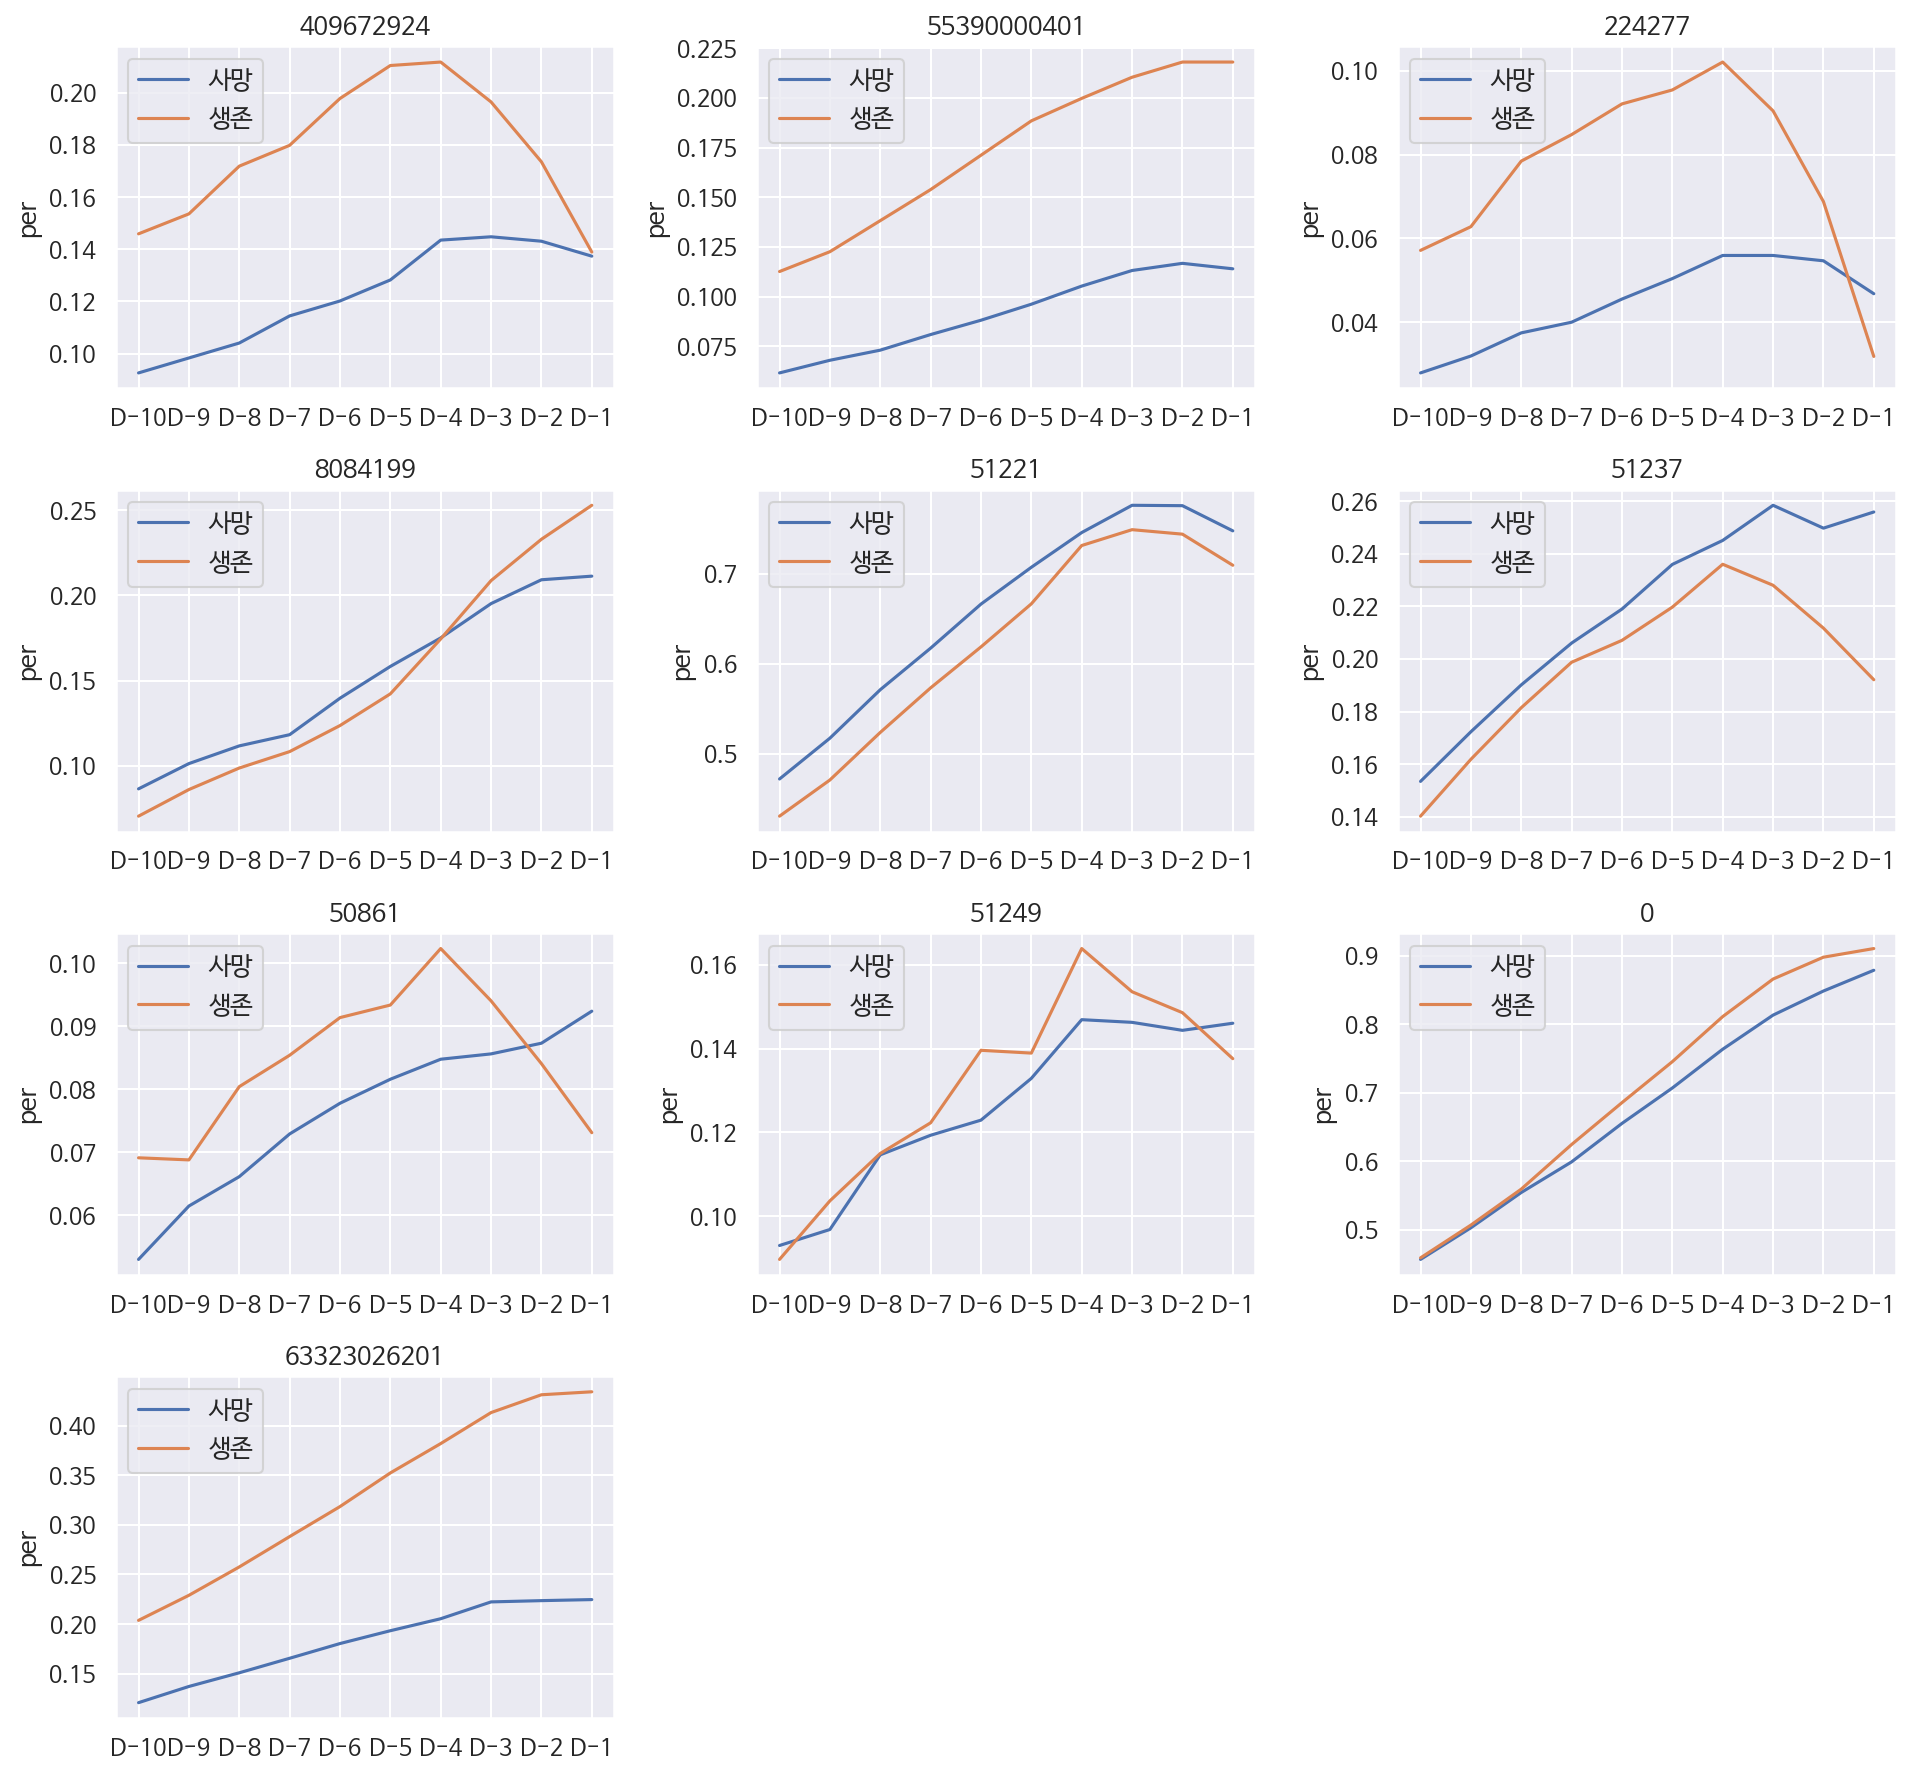

In [22]:
m1_new_bottom10 = list(m1_new_bottom10)
absum(m1_new_bottom10,m1_new_bottom10[:10])

## violin plot 

100%|██████████| 10/10 [00:48<00:00,  4.85s/it]


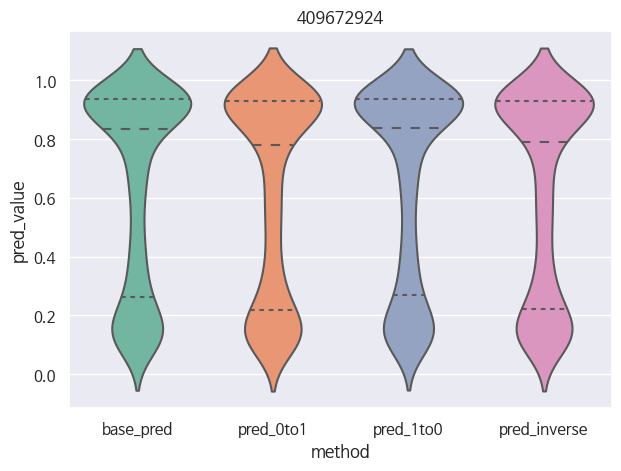

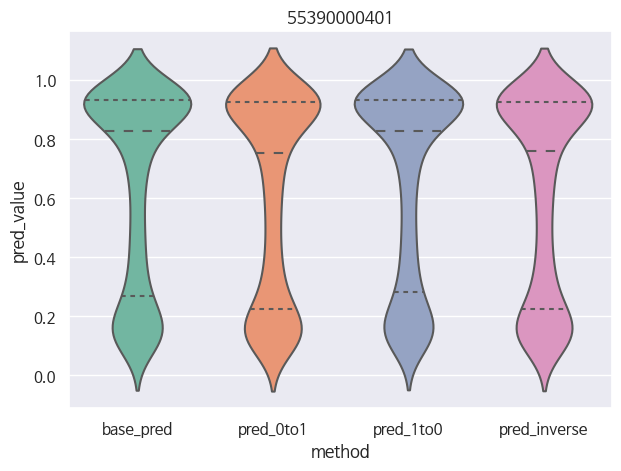

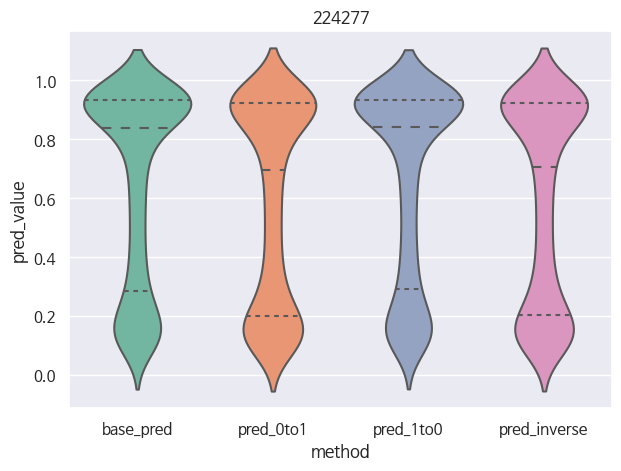

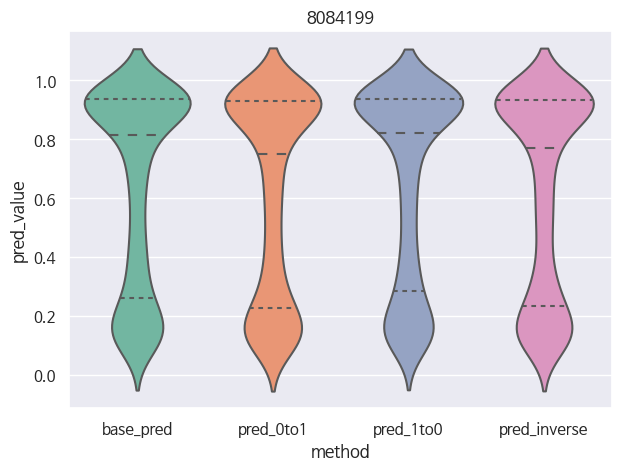

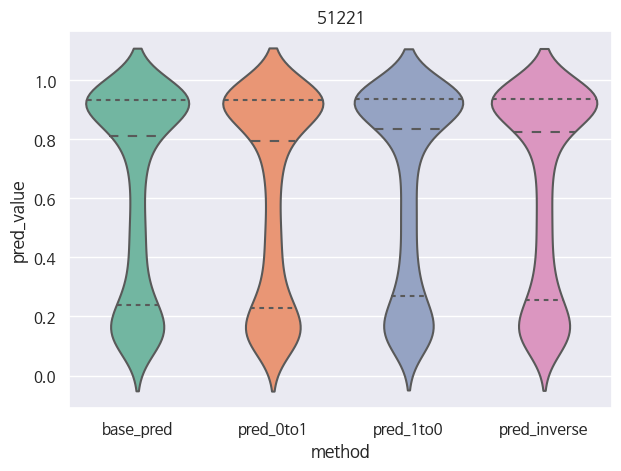

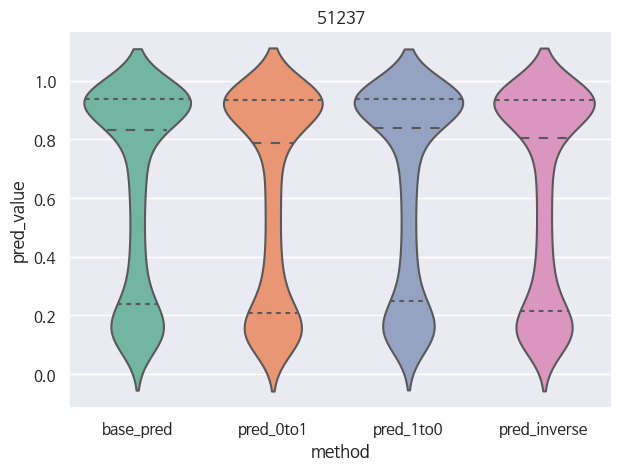

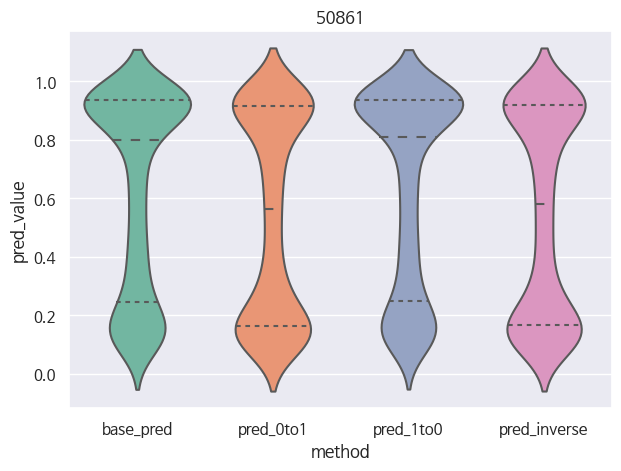

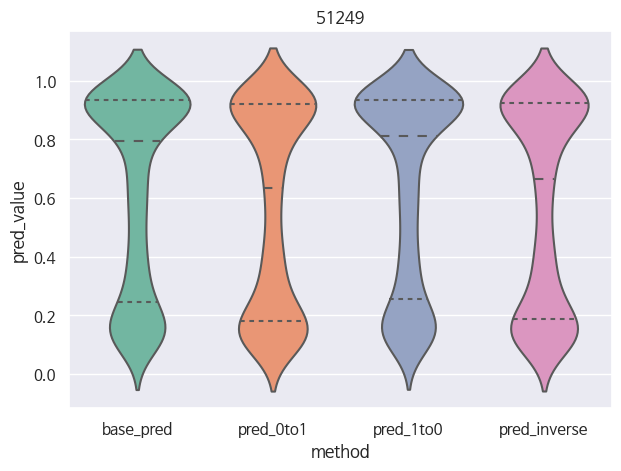

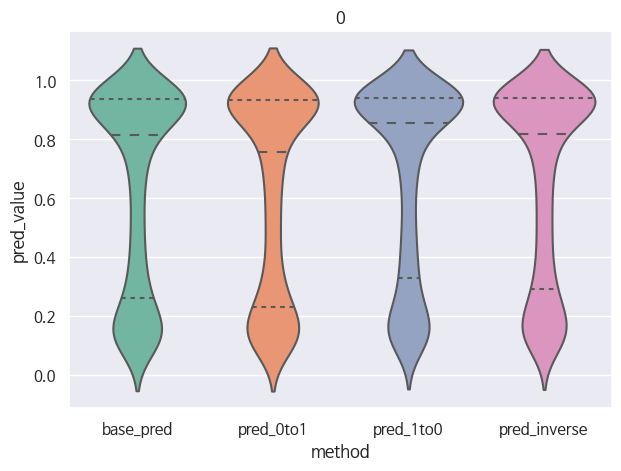

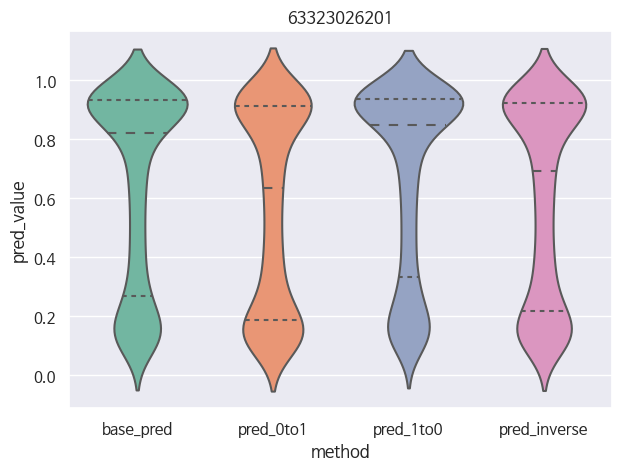

In [26]:
for i in tqdm(m1_new_bottom10):
    FI_merge(i)